<a href="https://colab.research.google.com/github/bjg5091/Capstone-3-COVID-Image-Processing/blob/main/Notebooks/Capstone_3_Triple_Layer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.color
import skimage.filters
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

#data = pd.read_csv('metadata.csv')

from google.colab import files
#uploaded = files.upload()

print(tf.__version__)

2.12.0


In [ ]:
import io

In [ ]:
import cv2
import glob
from skimage.filters import gaussian
from skimage import img_as_ubyte
from google.colab import drive
drive.mount('RadiographyDataset/')

Mounted at RadiographyDataset/


In [ ]:
#Import the libraries
import zipfile
import os


zip_ref = zipfile.ZipFile('/content/RadiographyDataset/MyDrive/RadiographyDataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
import pathlib

image_list = []
path = '/tmp/RadiographyDataset/RadiographyDataset'
data_dir = pathlib.Path(path).with_suffix('')
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

/tmp/RadiographyDataset/RadiographyDataset
21165


In [ ]:
image_list = []
path_covid = '/tmp/COVID-19_Radiography_Dataset/COVID/*.*'

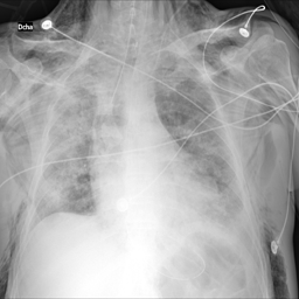

In [ ]:
covid = list(data_dir.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

In [ ]:
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.6,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 8466 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


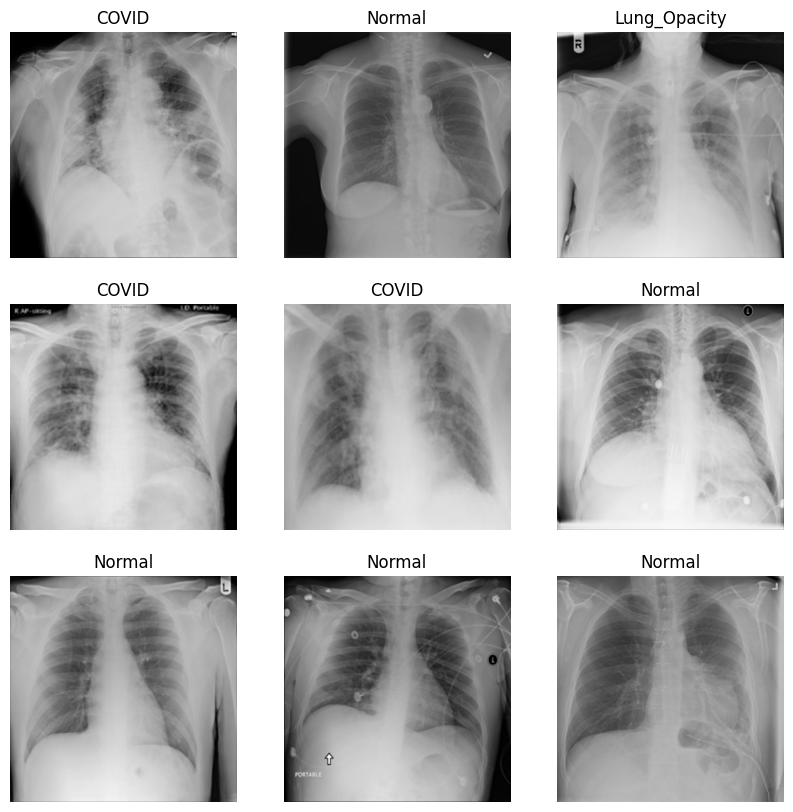

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


In [ ]:
from PIL import Image
import random 
imsize = (299,299)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.73333335


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



In [ ]:
base_learning_rate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
this_model = model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=128, verbose=1, callbacks = [es])

Epoch 1/15
265/265 [==============================] - 34s 83ms/step - loss: 0.9459 - accuracy: 0.6034 - val_loss: 1.0491 - val_accuracy: 0.5425
Epoch 2/15
265/265 [==============================] - 19s 73ms/step - loss: 0.6998 - accuracy: 0.7131 - val_loss: 0.9887 - val_accuracy: 0.5803
Epoch 3/15
265/265 [==============================] - 19s 73ms/step - loss: 0.5759 - accuracy: 0.7716 - val_loss: 0.8894 - val_accuracy: 0.6408
Epoch 4/15
265/265 [==============================] - 19s 73ms/step - loss: 0.4975 - accuracy: 0.8055 - val_loss: 0.8251 - val_accuracy: 0.6895
Epoch 5/15
265/265 [==============================] - 19s 73ms/step - loss: 0.4360 - accuracy: 0.8355 - val_loss: 0.6248 - val_accuracy: 0.7519
Epoch 6/15
265/265 [==============================] - 19s 73ms/step - loss: 0.3875 - accuracy: 0.8529 - val_loss: 0.5912 - val_accuracy: 0.7689
Epoch 7/15
265/265 [==============================] - 19s 73ms/step - loss: 0.3488 - accuracy: 0.8651 - val_loss: 0.5278 - val_accuracy:

In [ ]:
accuracy = this_model.history['accuracy']
val_accuracy = this_model.history['val_accuracy']
loss = this_model.history['loss']
val_loss = this_model.history['val_loss']

print(np.max(val_accuracy))

0.8275047540664673


In [ ]:
epoch_range = range(1, len(accuracy)+1)

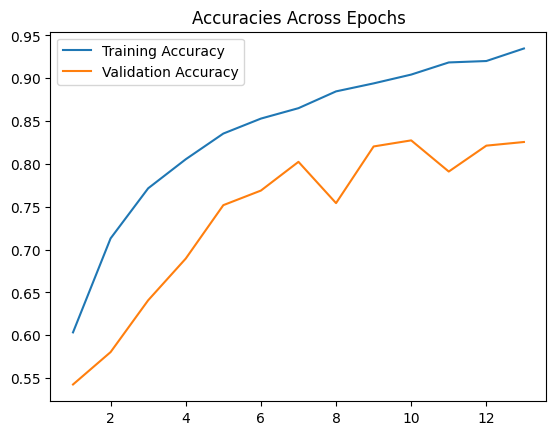

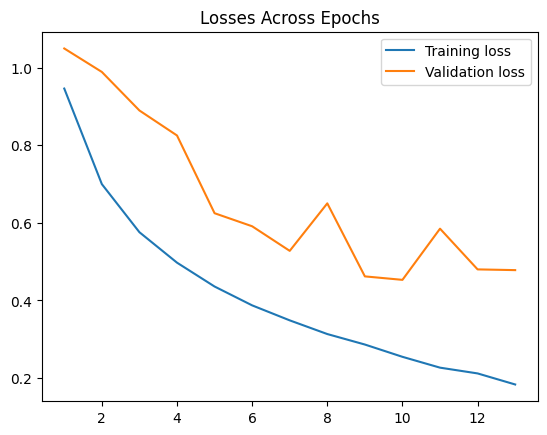

In [ ]:
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracies Across Epochs')
plt.legend()
plt.figure()
## saved as epochs_accuracies.png

plt.plot(epoch_range, loss,  label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Losses Across Epochs')
plt.legend()
plt.show()        
## saved as epochs_losses.png

In [ ]:
y_pred = model.predict(train_ds)
print(class_names[np.argmax(y_pred[1])])

265/265 [==============================] - 5s 17ms/step
Lung_Opacity


In [ ]:
model.evaluate(val_ds)

67/67 [==============================] - 1s 19ms/step - loss: 0.4782 - accuracy: 0.8256


[0.4782375991344452, 0.8256143927574158]